In [32]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.dates as mdates
import torch.nn.functional as F
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error, r2_score
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [33]:
Data=pd.read_excel("QBO Data.xlsx")
columns_name = ['25 hPa']
data = pd.DataFrame(Data, columns=columns_name)
# time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
Data['Date'] = pd.to_datetime(Data['Date'], format='%d%m%Y')
Data.set_index('Date', inplace=True)

In [34]:
data.head()

,25 hPa
0,-289
1,-280
2,-309
3,-303
4,-289


In [35]:
data.shape

(419, 1)

In [36]:
data.columns

Index(['25 hPa'], dtype='object')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   25 hPa  419 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [38]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=28).mean()
    MSTD = timeseries.rolling(window=28).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [39]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

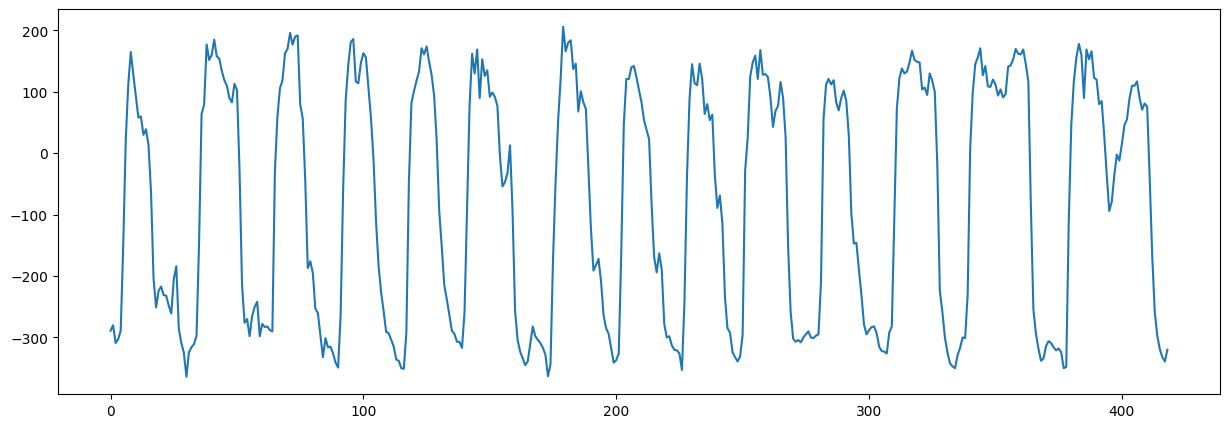

In [40]:
plt.figure(figsize = (15,5))
data['25 hPa'].plot();

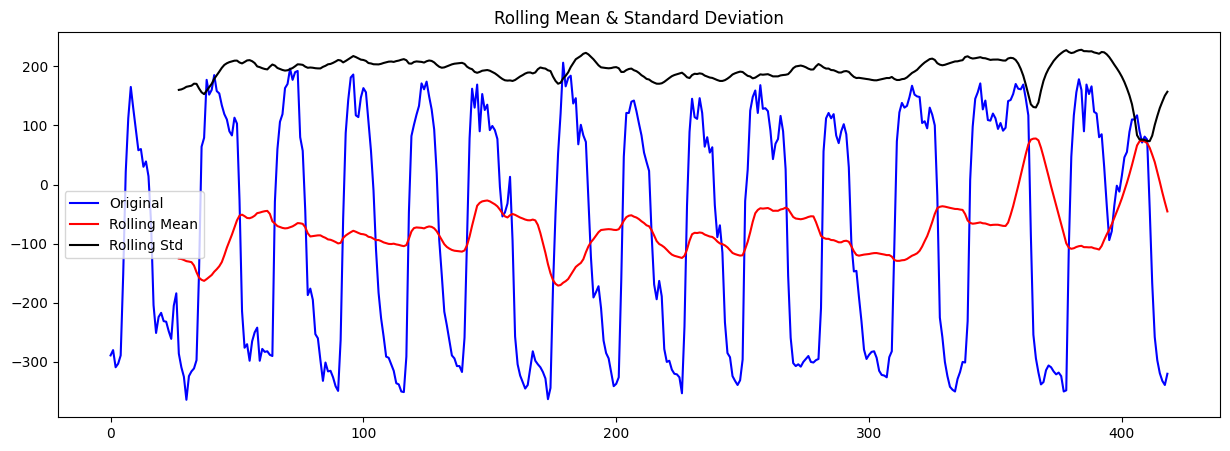

Results of Dickey-Fuller Test:
Test Statistic                -8.942076e+00
p-value                        9.195652e-15
#Lags Used                     1.100000e+01
Number of Observations Used    4.070000e+02
Critical Value (1%)           -3.446520e+00
Critical Value (5%)           -2.868668e+00
Critical Value (10%)          -2.570567e+00
dtype: float64


In [41]:
test_stationarity(data['25 hPa'])

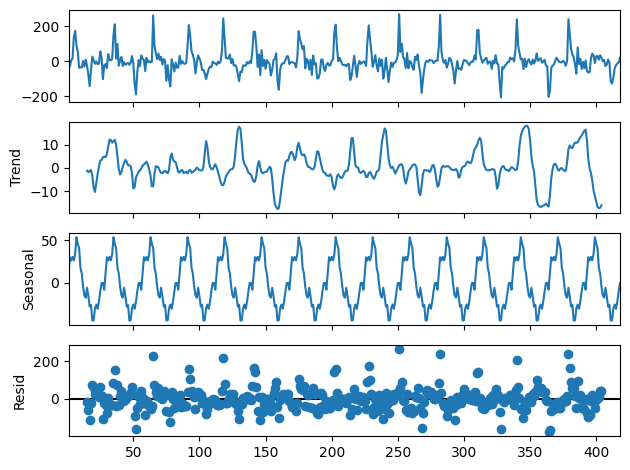

In [42]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 28).plot()
plt.show()

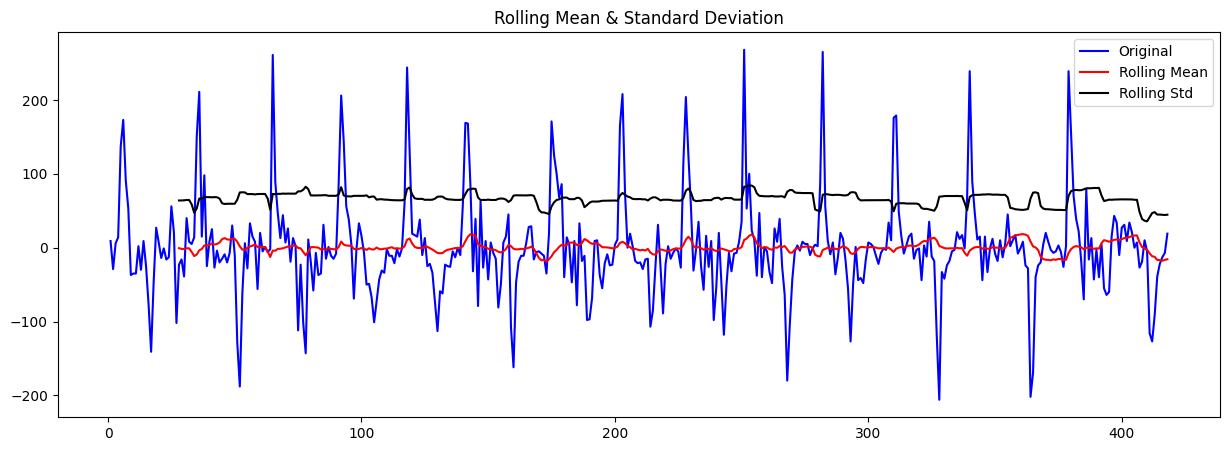

Results of Dickey-Fuller Test:
Test Statistic                -9.116292e+00
p-value                        3.295583e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.000000e+02
Critical Value (1%)           -3.446804e+00
Critical Value (5%)           -2.868793e+00
Critical Value (10%)          -2.570634e+00
dtype: float64


In [43]:
test_stationarity(data_diff)

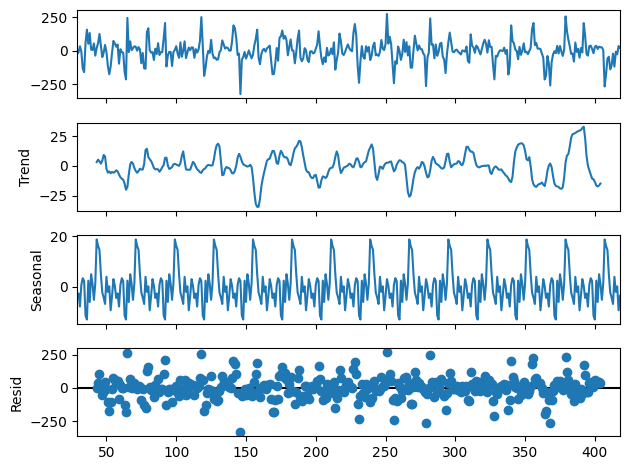

In [44]:
data_diff_seas = data_diff.diff(28)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 28)
dec.plot()
plt.show()

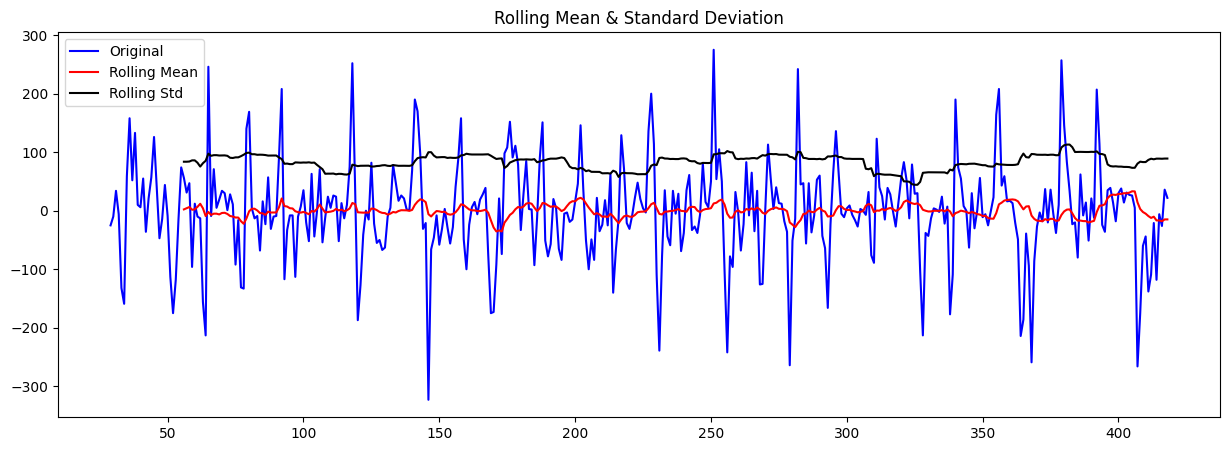

Results of Dickey-Fuller Test:
Test Statistic                -1.174556e+01
p-value                        1.243920e-21
#Lags Used                     2.000000e+00
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


In [45]:
test_stationarity(data_diff_seas['25 hPa'])

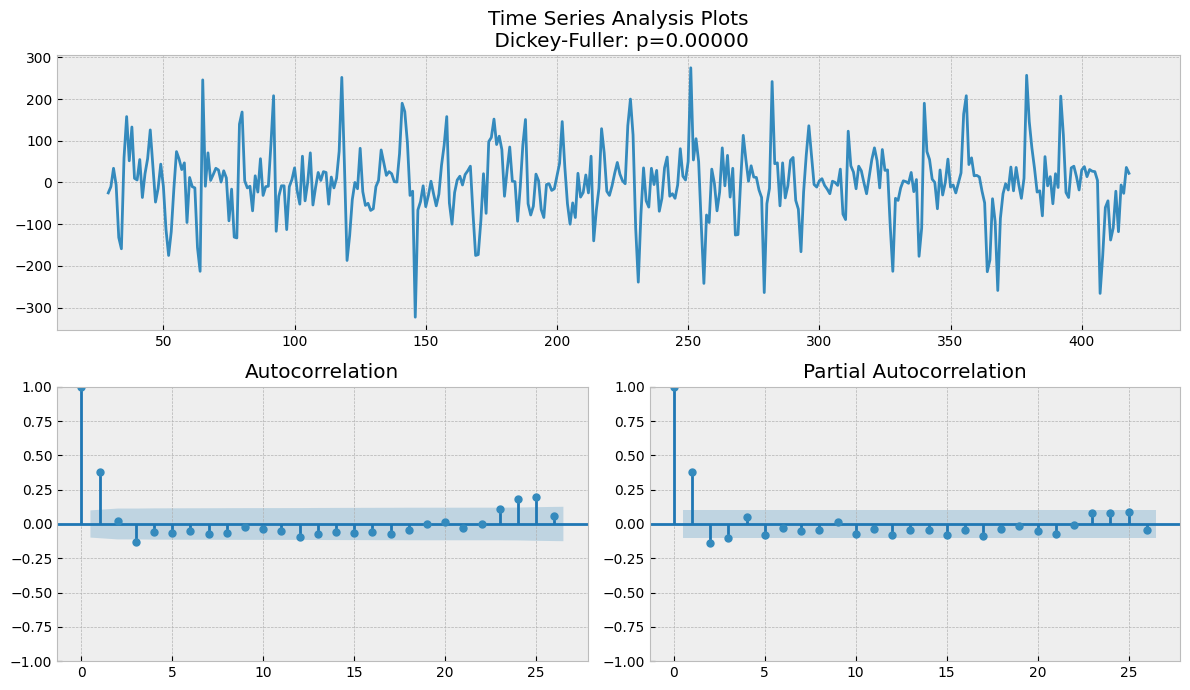

In [46]:
tsplot(data_diff_seas['25 hPa'])

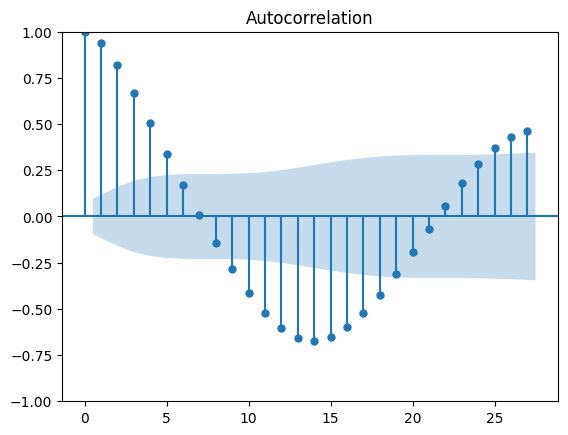

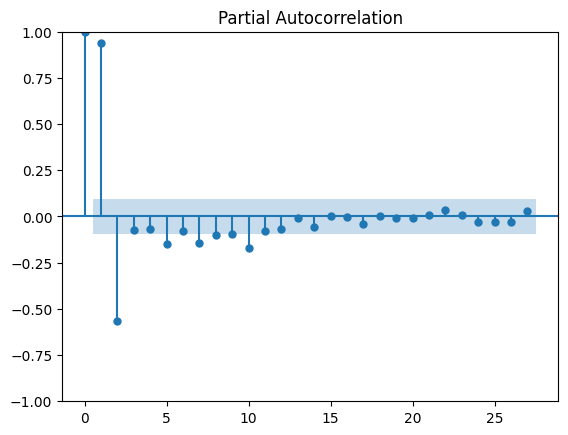

In [47]:
plot_acf(data)
plot_pacf(data)
plt.show()

In [48]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Misal: data sudah dalam format time series dan bernama data
# data harus berupa Series dengan index berupa datetime
# Contoh:
# data = pd.read_csv("yourfile.csv", index_col='Date', parse_dates=True)

# Parameter ranges
p = d = q = range(0, 3)       # (p,d,q) from 0 to 2
P = D = Q = range(0, 2)       # (P,D,Q) from 0 to 1
m = 28                        # Musim QBO

# Generate semua kombinasi parameter
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

# Untuk menyimpan hasil AIC
results = []

# Grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(data,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results_fit = model.fit(disp=False)
            results.append({
                'order': param,
                'seasonal_order': seasonal_param,
                'AIC': results_fit.aic
            })
        except:
            continue

# Konversi ke DataFrame dan sortir
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

# Tampilkan model terbaik
print("Model SARIMA terbaik berdasarkan AIC:")
print(results_df.head(1))

# Jika ingin semua model disortir berdasarkan AIC
print("\nTop 5 model dengan AIC terendah:")
print(results_df.head(5))

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftw

Model SARIMA terbaik berdasarkan AIC:
       order seasonal_order          AIC
0  (2, 0, 2)  (0, 1, 1, 28)  3916.555828

Top 5 model dengan AIC terendah:
       order seasonal_order          AIC
0  (2, 0, 2)  (0, 1, 1, 28)  3916.555828
1  (2, 0, 2)  (1, 1, 1, 28)  3918.224360
2  (1, 0, 2)  (0, 1, 1, 28)  3935.425782
3  (2, 1, 1)  (0, 1, 1, 28)  3936.966636
4  (1, 0, 2)  (1, 1, 1, 28)  3937.425700


In [49]:
# Fit model SARIMA terbaik
model = SARIMAX(data,
                order=(2, 0, 2),
                seasonal_order=(0, 1, 1, 28),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit()

# Ringkasan model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               25 hPa   No. Observations:                  419
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 28)   Log Likelihood               -1952.278
Date:                              Sat, 05 Jul 2025   AIC                           3916.556
Time:                                      23:48:41   BIC                           3939.872
Sample:                                           0   HQIC                          3925.827
                                              - 419                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8550      0.027     68.528      0.000       1.802       1.908
ar.L2         -0.89

In [50]:
# Hasil koefisien dari model_fit
phi1 = 1.8550
phi2 = -0.8964
theta1 = -0.5642
theta2 = -0.3078
thetaS = -1.0001  # MA musiman pada lag 28

# Tampilkan rumus SARIMA
print("Rumus SARIMA dari hasil estimasi:")

print("""
(Y_t - {phi1:.4f} Y_(t-1) {phi2:+.4f} Y_(t-2) - Y_(t-28) + {phi1:.4f} Y_(t-29) {phi2:+.4f} Y_(t-30)) =
    (e_t {theta1:+.4f} e_(t-1) {theta2:+.4f} e_(t-2) {thetaS:+.4f} e_(t-28) {prod1:+.4f} e_(t-29) {prod2:+.4f} e_(t-30))
""".format(
    phi1=phi1, phi2=phi2,
    theta1=theta1, theta2=theta2, thetaS=thetaS,
    prod1=theta1*thetaS,
    prod2=theta2*thetaS
))

# Penjelasan: Y_t = data pada waktu t, e_t = error pada waktu t

Rumus SARIMA dari hasil estimasi:

(Y_t - 1.8550 Y_(t-1) -0.8964 Y_(t-2) - Y_(t-28) + 1.8550 Y_(t-29) -0.8964 Y_(t-30)) =
    (e_t -0.5642 e_(t-1) -0.3078 e_(t-2) -1.0001 e_(t-28) +0.5643 e_(t-29) +0.3078 e_(t-30))



In [51]:
# Split data menjadi data latih dan data uji 70:30
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, shuffle=False)

In [52]:
train_pred = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
test_pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)  # Prediksi untuk data uji

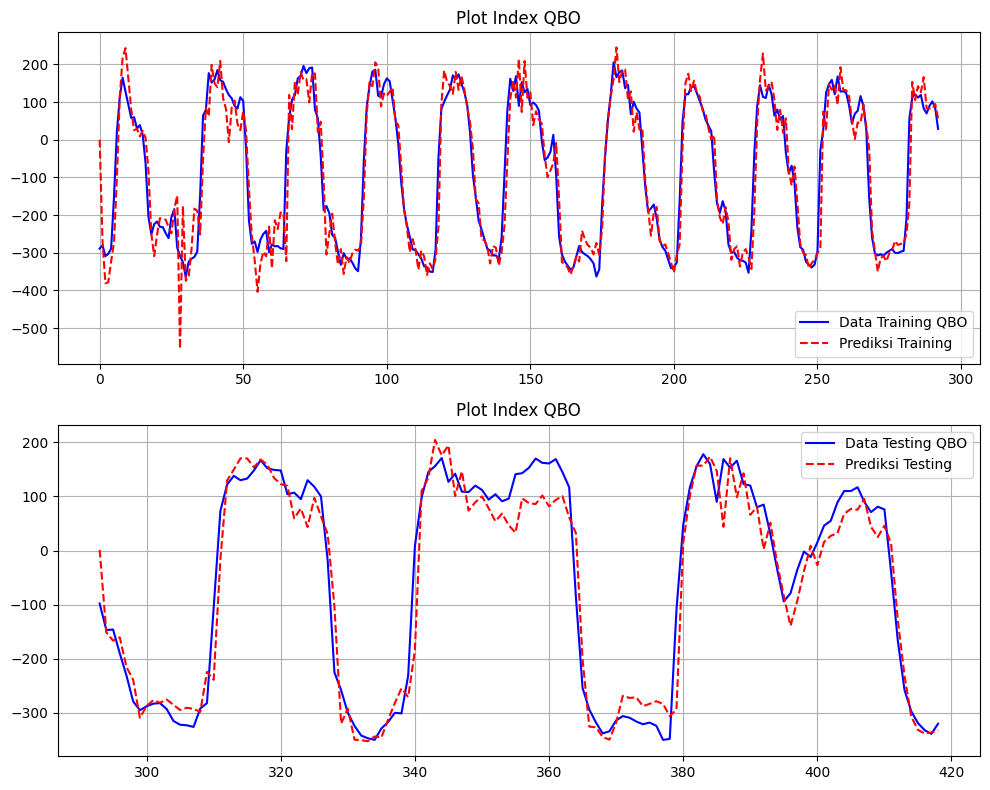

In [53]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  

# Plot pertama
axs[0].plot(train.index, train, label='Data Training QBO', color='blue')
axs[0].plot(train.index, train_pred, label="Prediksi Training", color='red', linestyle='--')
axs[0].set_title('Plot Index QBO')
axs[0].legend()
axs[0].grid(True)

# Plot kedua
axs[1].plot(test.index, test, label='Data Testing QBO', color='blue')
axs[1].plot(test.index, test_pred, label="Prediksi Testing", color='red', linestyle='--')
axs[1].set_title('Plot Index QBO')
axs[1].legend()
axs[1].grid(True)


# Menambahkan jarak antara subplot
plt.tight_layout()

# Menampilkan plot
plt.show()

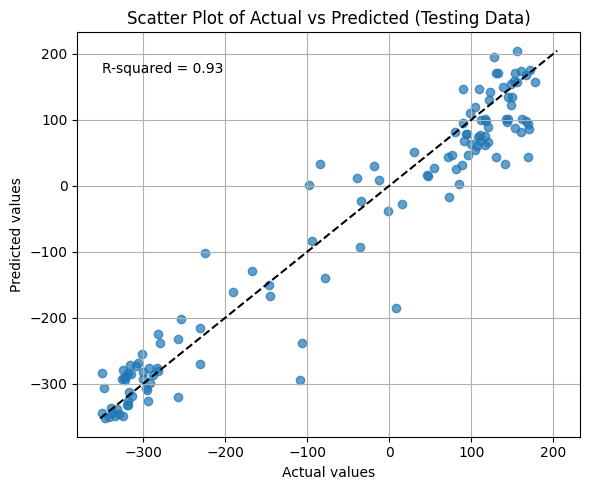

In [54]:
# Pastikan data dalam bentuk array 1D
y_test_actual = np.array(test)
y_test_pred = np.array(test_pred)

# Hitung R-squared
r2 = r2_score(y_test_actual, y_test_pred)

# Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test_actual, y_test_pred, alpha=0.7)

# Garis referensi (prediksi sempurna)
min_val = min(y_test_actual.min(), y_test_pred.min())
max_val = max(y_test_actual.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs Predicted (Testing Data)")

# Tampilkan nilai R² di dalam plot
plt.text(0.05, 0.90, f"R-squared = {r2:.2f}", transform=plt.gca().transAxes)

plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
# MSE (Mean Squared Error)                          % Data Training
mse_train = mean_squared_error(train, train_pred)
# RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mse_train)
# MAE (Mean Absolute Error)
mae_train = mean_absolute_error(train, train_pred)
# R2 (Coefficient of Determination)
r2_train = r2_score(train, train_pred)

# MSE (Mean Squared Error)                          % Data Testing
mse_test = mean_squared_error(test, test_pred)
# RMSE (Root Mean Squared Error)
rmse_test = np.sqrt(mse_test)
# MAE (Mean Absolute Error)
mae_test = mean_absolute_error(test, test_pred)
# R2 (Coefficient of Determination)
r2_test = r2_score(test, test_pred)

# Display metrics in a DataFrame
metrics_data = {
    'Metric': ['R\N{SUPERSCRIPT TWO}', 'MAE', 'MSE', 'RMSE'],
    'Train Data': [r2_train, mae_train, mse_train, rmse_train],
    'Test Data': [r2_test, mae_test, mse_test, rmse_test]}

metrics_qbo = pd.DataFrame(metrics_data)
metrics_qbo = metrics_qbo.round(4)

print(metrics_qbo)

  Metric  Train Data  Test Data
0     R²      0.8886     0.9344
1    MAE     45.0931    37.5626
2    MSE   4096.9869  2574.0131
3   RMSE     64.0077    50.7347


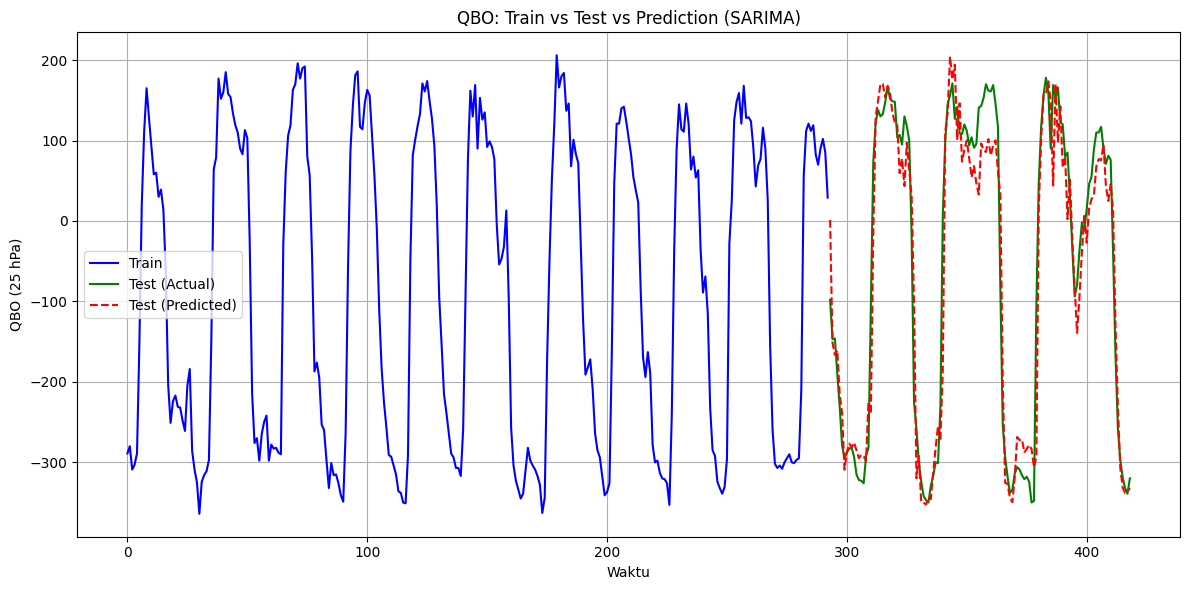

In [56]:
# Pastikan index tetap konsisten dengan `data`
train_index = data.index[:len(train)]
test_index = data.index[len(train):]

# Plot
plt.figure(figsize=(12, 6))

# Plot Train data
plt.plot(train_index, train, label='Train', color='blue')

# Plot Test Actual
plt.plot(test_index, test, label='Test (Actual)', color='green')

# Plot Test Prediction
plt.plot(test_index, test_pred, label='Test (Predicted)', color='red', linestyle='--')

# Tambahan gaya dan label
plt.title('QBO: Train vs Test vs Prediction (SARIMA)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


ADF Statistic: -13.019079486870526
P-Value: 2.475483904192821e-24
✅ Residual bersifat stasioner (white noise).


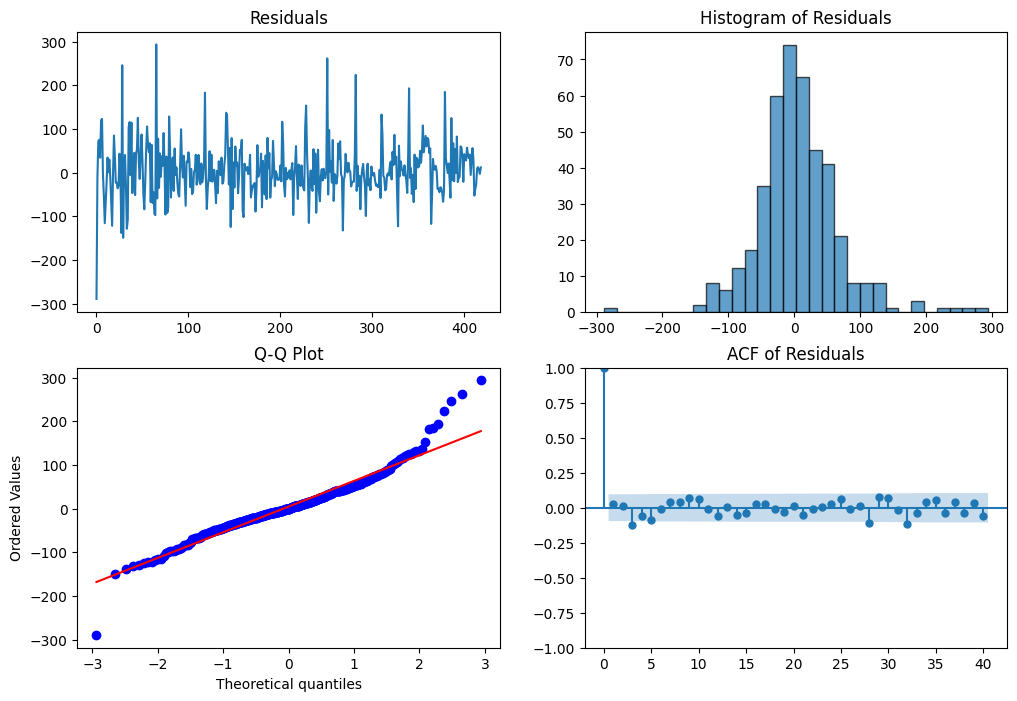

In [57]:
from scipy.stats import probplot

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ===== Analisis Residual =====
residuals = model_fit.resid

# Plot residuals
axes[0, 0].plot(residuals)
axes[0, 0].set_title("Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor="k", alpha=0.7)
axes[0, 1].set_title("Histogram of Residuals")

# Q-Q plot
probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot")

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title("ACF of Residuals")

# Uji ADF
adf_stat, p_value, _, _, _, _ = adfuller(residuals)
print(f"ADF Statistic: {adf_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("✅ Residual bersifat stasioner (white noise).")
else:
    print("⚠️ Residual tidak stasioner. Model bisa ditingkatkan.")

In [58]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residual dari model_fit
residuals = model_fit.resid

# Pilih lags yang ingin diuji
lags = [12, 24, 36, 48]

# Jalankan uji Ljung-Box
ljung = acorr_ljungbox(residuals, lags=lags, return_df=True)

# Buat DataFrame hasil
tabel = pd.DataFrame({
    'Lags': lags,
    'Stat. value': ljung['lb_stat'].values,
    'p-value': ljung['lb_pvalue'].values
})

# Kolom Keterangan (Lolos jika p-value > 0.05)
tabel['Ket.'] = tabel['p-value'].apply(lambda x: "Lolos" if x > 0.05 else "Tidak")

# Tampilkan tabel
print("Uji White Noise")
print(tabel)

# Untuk tampilan seperti tabel di gambar (misal ingin tabel markdown atau latex):
from IPython.display import display
display(tabel.style.format({"Stat. value": "{:.6f}", "p-value": "{:.6g}"}))

Uji White Noise
   Lags  Stat. value   p-value   Ket.
0    12    18.275180  0.107587  Lolos
1    24    22.611356  0.542826  Lolos
2    36    45.150587  0.141029  Lolos
3    48    51.332853  0.344463  Lolos


,Lags,Stat. value,p-value,Ket.
0,12,18.275180,0.107587,Lolos
1,24,22.611356,0.542826,Lolos
2,36,45.150587,0.141029,Lolos
3,48,51.332853,0.344463,Lolos


In [59]:
# Ambil residual (sisa error) dari hasil fitting model SARIMA
residuals = model_fit.resid

# Tampilkan 10 nilai residual pertama
print(residuals.head(10))

# Jika ingin semua residual dalam bentuk tabel/dataframe:
import pandas as pd
residuals_df = pd.DataFrame(residuals, columns=['Residual'])
print(residuals_df)

# Atau simpan ke Excel/CSV jika ingin diolah di luar Python
residuals_df.to_excel('residual_sarima.xlsx')
residuals_df.to_csv('residual_sarima.csv')

0   -289.000000
1    -11.954489
2     72.230803
3     75.184301
4     34.349906
5    120.175014
6    123.034095
7     -1.348747
8    -52.669482
9   -115.462356
dtype: float64
       Residual
0   -289.000000
1    -11.954489
2     72.230803
3     75.184301
4     34.349906
..          ...
414    9.850500
415   12.558455
416    6.015926
417   -2.654686
418   12.024296

[419 rows x 1 columns]


In [60]:
print(residuals.iloc[99])  # karena index mulai dari 0

23.99834285445135


C:\Users\HP\AppData\Local\Temp\ipykernel_29892\259167359.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast, freq='M')


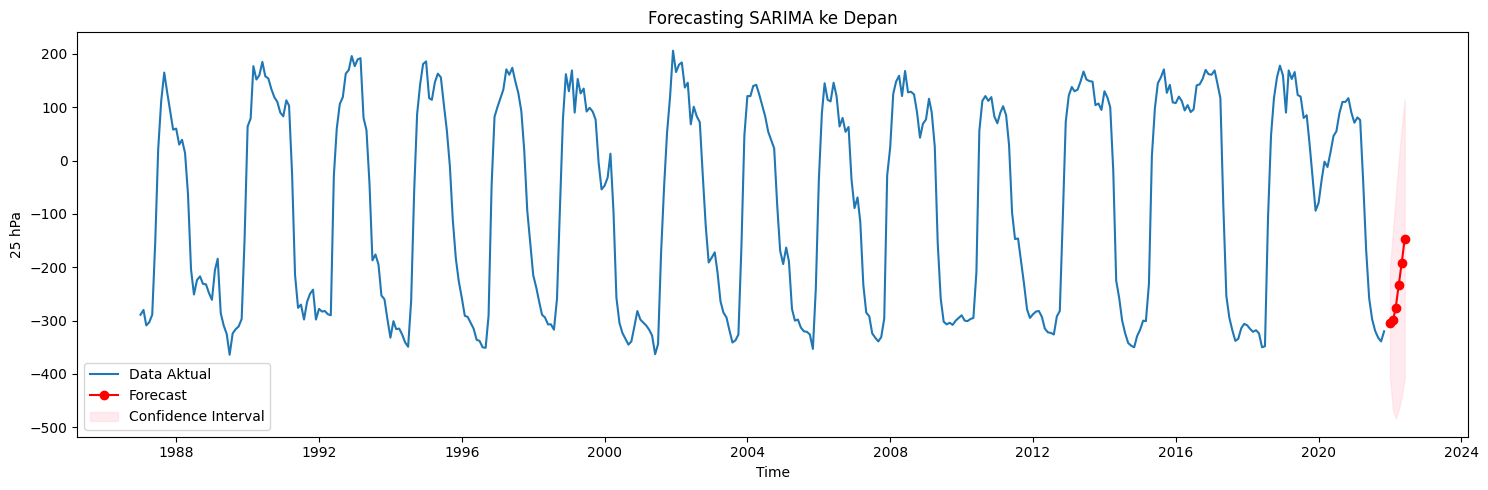

Hasil Forecasting:
2021-12-31: -304.76
2022-01-31: -299.57
2022-02-28: -275.41
2022-03-31: -232.70
2022-04-30: -191.48
2022-05-31: -146.44


In [61]:
n_forecast = 6  # Ganti dengan jumlah periode ke depan yang diinginkan
forecast = model_fit.get_forecast(steps=n_forecast)

# Ambil tanggal terakhir dari Data yang sudah datetime index
last_date = Data.index[-1]

# Untuk data bulanan, gunakan pd.DateOffset(months=1)
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast, freq='M')

forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(15, 5))
plt.plot(Data.index, Data['25 hPa'], label='Data Aktual')
plt.plot(forecast_index, forecast_values, color='red', marker='o', label='Forecast')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Forecasting SARIMA ke Depan')
plt.xlabel('Time')
plt.ylabel('25 hPa')
plt.legend()
plt.tight_layout()
plt.show()

print("Hasil Forecasting:")
for date, value in zip(forecast_index, forecast_values):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")